In [1]:
!pip install tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 41kB/s 
     |████████████████████████████████| 460kB 44.5MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 4.3MB/s 
     |████████████████████████████████| 1.6MB 37.3MB/s 
     |████████████████████████████████| 5.6MB 33.6MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


In [3]:
!pip install cirq

In [4]:
import tensorflow as tf 
import tensorflow_quantum as tfq 
import cirq 
import sympy 
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


N total train:  60000
N total test:  10000
filtered N train: 12049
filtered N test: 1968


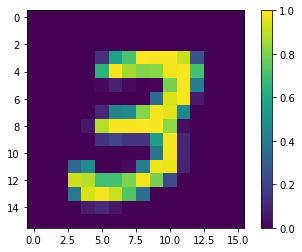

In [22]:
import collections 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("N total train: ", len(x_train))
print("N total test: ", len(x_test))

def filter_36(x,y):
  keep = (y==3)|(y==6)
  x, y = x[keep], y[keep]
  y = y == 3
  return x,y 

x_train_, y_train_ = filter_36(x_train, y_train)
x_test_, y_test_ = filter_36(x_test, y_test)

print('filtered N train:' , len(x_train_))
print('filtered N test:', len(x_test_))

size = 16
x_train_small = tf.image.resize(x_train_, (size,size)).numpy()
x_test_small = tf.image.resize(x_test_, (size,size)).numpy()

def convert_label(y):
  if y==True:
    return 1.0
  else: 
    return -1.0  #changed from -1.0

y_train_ = [convert_label(y) for y in y_train_]
y_test_ = [convert_label(y) for y in y_test_]

plt.imshow(x_train_small[0,:,:,0], vmin = 0, vmax = 1 )
plt.colorbar()

X_train = x_train_small[:300]
X_test = x_test_small[:50]
Y_train = y_train_[:300]
Y_test = y_test_[:50]


In [30]:
#Try 4 qubit gates -- to be improved later

from sympy.physics.quantum import TensorProduct
class ZZZZ(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.ZZ),cirq.unitary(cirq.ZZ))**self.symbols
  def __str__(self):
    return 'ZZZZ'


class XXXX(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.XX),cirq.unitary(cirq.XX))**self.symbols
  def __str__(self):
    return 'XXXX'

class YYYY(cirq.Gate):
  def __init__(self, symbols):
    self.symbols=symbols
  def _num_qubits_(self) -> int:
    return 4
  def _unitary_(self):
    return TensorProduct(cirq.unitary(cirq.YY),cirq.unitary(cirq.YY))**self.symbols
  def __str__(self):
    return 'YYYY'

In [10]:
def one_qubit_unitary(bit, symbols):
  """Rotation of bloch sphere about X, Y and Z axis, that depends on values in symbols"""
  return cirq.Circuit(
      cirq.X(bit)**symbols[0],
      cirq.Y(bit)**symbols[1],
      cirq.Z(bit)**symbols[2])
  
def conv_filter_4(bits, symbols):
  circuit=cirq.Circuit()
  """
  circuit += one_qubit_unitary(bits[0], symbols[0:3])
  circuit += one_qubit_unitary(bits[1], symbols[3:6])
  circuit += one_qubit_unitary(bits[2], symbols[6:9])
  circuit += one_qubit_unitary(bits[3], symbols[9:12])
  """
  
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += [cirq.ZZ(first, second)**symbols[0]]
    circuit += [cirq.YY(first, second)**symbols[1]]
    circuit += [cirq.XX(first, second)**symbols[2]]

  
  circuit += one_qubit_unitary(bits[0], symbols[3:6])
  circuit += one_qubit_unitary(bits[1], symbols[6:9])
  circuit += one_qubit_unitary(bits[2], symbols[9:12])
  circuit += one_qubit_unitary(bits[3], symbols[12:])
  
  
#pooling
  circuit+=cirq.CNOT(control=bits[0], target=bits[1])
  circuit+=cirq.CNOT(control=bits[2], target=bits[3])
  circuit+=cirq.CNOT(control=bits[1], target=bits[3])
  #circuit+=cirq.PauliSum(bits)

  return circuit 



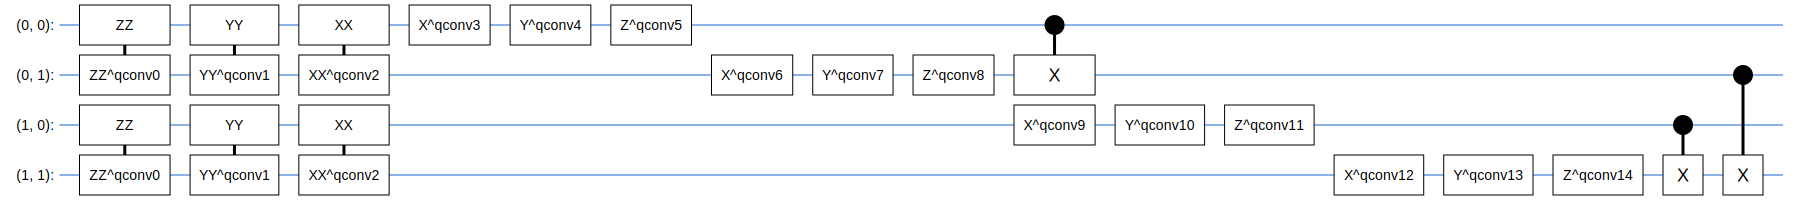

In [11]:
qubits = cirq.GridQubit.rect(2,2)
symbols = sympy.symbols('qconv0:100')
SVGCircuit(conv_filter_4(qubits, symbols))

In [40]:
conv_filter_4(qubits, symbols)

(0, 0): ───ZZ──────────YY──────────XX──────────@───────
           │           │           │           │
(0, 1): ───ZZ^qconv0───YY^qconv1───XX^qconv2───X───@───
                                                   │
(1, 0): ───ZZ──────────YY──────────XX──────────@───┼───
           │           │           │           │   │
(1, 1): ───ZZ^qconv0───YY^qconv1───XX^qconv2───X───X───

In [33]:
#encode images to quantum states
def encode_circuit(image):
  #im4 = values[1:5,1:5]
  
  n=16
  all_circuits = []
  qubits = cirq.GridQubit.rect(2,2)
  #patch=np.array(bits).reshape((2,2))
  for j in range(0,n,2):
    for k in range(0,n,2):
      image_patch = np.ndarray.flatten(image[j:j+2,k:k+2])
      #image_patch = [image[j,k,0], image[j, k+1,0], image[j+1, k,0], image[j+1, k+1,0]]
      sub_circuit = cirq.Circuit()
      for i in range(4):
        sub_circuit.append(cirq.ry(np.pi*image_patch[i])(qubits[i]))
      all_circuits.append(sub_circuit)
  return all_circuits

In [8]:
#encode images to quantum states
def encode_circuit_2(image):
  #im4 = values[1:5,1:5]
  
  n=16
  all_circuits = cirq.Circuit()
  qubits = cirq.GridQubit.rect(2,2)
  #patch=np.array(bits).reshape((2,2))
  for j in range(0,n,2):
    for k in range(0,n,2):
      image_patch = np.ndarray.flatten(image[j:j+2,k:k+2])
      #image_patch = [image[j,k,0], image[j, k+1,0], image[j+1, k,0], image[j+1, k+1,0]]
      #sub_circuit = cirq.Circuit()
      for i in range(4):
        all_circuits.append(cirq.ry(np.pi*image_patch[i])(qubits[i]))
      #all_circuits.append(sub_circuit)
  return all_circuits

In [36]:
x_train_all = tfq.convert_to_tensor([encode_circuit(x) for x in X_train])
x_test_all = tfq.convert_to_tensor([encode_circuit(x) for x in X_test])

In [37]:
trial =encode_circuit(X_train[0])

In [39]:
trial[30]

(0, 0): ───Ry(0.074π)───

(0, 1): ───Ry(0)────────

(1, 0): ───Ry(0.008π)───

(1, 1): ───Ry(0)────────

In [23]:
x_train_all = tfq.convert_to_tensor([encode_circuit_2(x) for x in X_train])
x_test_all = tfq.convert_to_tensor([encode_circuit_2(x) for x in X_test])

In [24]:
def conv_circuit_2(qubits, symbols, pixels=None): #2x2 pixelleri alıcaz
  circuit = cirq.Circuit()
  #qubits = cirq.GridQubit.rect(2,2)
  
  if pixels is not None:
    pixels = np.array(pixels)
    qubits = cirq.GridQubit.rect(2,2)
    for i in range(4):
      circuit.append(cirq.ry(np.pi*pixels[i])(qubits[i]))
  
  circuit+= conv_filter_4([qubits[i] for i in range(4)], symbols[0:16])
  op = sum([cirq.Z(qubits[i]) for i in range(4)])/4
  return circuit, op





In [25]:
def model_circuit_2(qubit_list):
  circuit =cirq.Circuit()
  out_exp =[]
  n=16
  #im0 = np.array(image).reshape((n,n))
  #im0=tf.reshape(image, [n,n])
  expectation_layer=tfq.layers.Expectation()
  
  #LAYER1 16x16
  layer1_circuit=cirq.Circuit()
  ops_layer1 = []
  count=-1
  for j in range(0,n,2):
    for k in range(0, n,2):
      count+=1
      layer1, op1 = conv_circuit_2(qubit_list[count], sympy.symbols('l1_0:16'))
      layer1_circuit+=layer1
      ops_layer1.append(op1)
  circuit.append(layer1_circuit)
  
  #LAYER2 8x8

  layer2_circuit=cirq.Circuit()
  layer1_out = expectation_layer(layer1_circuit, symbol_names =sympy.symbols('l1_0:16'), operators = ops_layer1)
  layer2_input = np.array(layer1_out).reshape((n//2, n//2))
  ops_layer2=[]
  for j in range(0,n//2, 2):
    for k in range(0, n//2, 2):
      layer2, op2 = conv_circuit_2(None, sympy.symbols('l2_0:16'), pixels=[layer2_input[j,k], layer2_input[j, k+1], layer2_input[j+1, k], layer2_input[j+1, k+1]])
      layer2_circuit+=layer2
      ops_layer2.append(op2)
  circuit.append(layer2_circuit)

  #LAYER3 4X4
  layer3_circuit=cirq.Circuit()
  layer2_out = expectation_layer(layer2_circuit, symbol_names =sympy.symbols('l2_0:16'), operators = ops_layer2)
  layer3_input = np.array(layer2_out).reshape((n//4, n//4))
  ops_layer3=[]
  for j in range(0,n//4, 2):
    for k in range(0, n//4, 2):
      layer3, op3 = conv_circuit_2(None, sympy.symbols('l3_0:16'), pixels=[layer3_input[j,k], layer3_input[j, k+1], layer3_input[j+1, k], layer3_input[j+1, k+1]])
      layer3_circuit+=layer3
      ops_layer3.append(op3)  
  circuit.append(layer3_circuit)

  #LAYER4 2x2
  layer4_circuit=cirq.Circuit()
  layer3_out = expectation_layer(layer3_circuit, symbol_names =sympy.symbols('l3_0:16'), operators = ops_layer3)
  layer4_input = np.array(layer3_out).reshape((n//8, n//8))
  ops_layer4=[]
  for j in range(0,n//8, 2):
    for k in range(0, n//8, 2):
      layer4, op4 = conv_circuit_2(None, sympy.symbols('l4_0:16'), pixels=[layer4_input[j,k], layer4_input[j, k+1], layer4_input[j+1, k], layer4_input[j+1, k+1]])
      layer4_circuit+=layer4
      ops_layer4.append(op4) 
  circuit.append(layer4_circuit)



  return circuit, ops_layer4


In [26]:
qubit_list = [cirq.GridQubit.rect(2,2)]*64

In [27]:
QCNN_circuit, readout = model_circuit_2(qubit_list)

In [ ]:
QCNN_circuit

In [ ]:
"""
def conv_circuit(pixels, symbols): #2x2 pixelleri alıcaz
  circuit = cirq.Circuit()
  qubits = cirq.GridQubit.rect(2,2)
  pixels = np.array(pixels)
  
  for i in range(4):
    circuit.append(cirq.ry(np.pi*pixels[i])(qubits[i]))
  
  circuit+= conv_filter_4([qubits[i] for i in range(4)], symbols[0:4])
  op = sum([cirq.Z(qubits[i]) for i in range(4)])/4
  return circuit, op

"""


In [ ]:
"""
def model_circuit(image):
  circuit =cirq.Circuit()
  out_exp =[]
  n=16
  #im0 = np.array(image).reshape((n,n))
  im0=tf.reshape(image, [n,n])
  expectation_layer=tfq.layers.Expectation()

  #LAYER1 16x16
  layer1_circuit=cirq.Circuit()
  ops_layer1 = []
  for j in range(0,n,2):
    for k in range(0, n,2):
      layer1, op1 = conv_circuit([im0[j,k], im0[j, k+1], im0[j+1, k], im0[j+1, k+1]], sympy.symbols('l1_0:3'))
      layer1_circuit+=layer1
      ops_layer1.append(op1)
  circuit.append(layer1_circuit)
  
  #LAYER2 8x8

  layer2_circuit=cirq.Circuit()
  layer1_out = expectation_layer(layer1_circuit, symbol_names =sympy.symbols('l1_0:3'), operators = ops_layer1)
  layer2_input = np.array(layer1_out).reshape((n//2, n//2))
  ops_layer2=[]
  for j in range(0,n//2, 2):
    for k in range(0, n//2, 2):
      layer2, op2 = conv_circuit([layer2_input[j,k], layer2_input[j, k+1], layer2_input[j+1, k], layer2_input[j+1, k+1]], sympy.symbols('l2_0:3'))
      layer2_circuit+=layer2
      ops_layer2.append(op2)
  circuit.append(layer2_circuit)

  #LAYER3 4X4
  layer3_circuit=cirq.Circuit()
  layer2_out = expectation_layer(layer2_circuit, symbol_names =sympy.symbols('l2_0:3'), operators = ops_layer2)
  layer3_input = np.array(layer2_out).reshape((n//4, n//4))
  ops_layer3=[]
  for j in range(0,n//4, 2):
    for k in range(0, n//4, 2):
      layer3, op3 = conv_circuit([layer3_input[j,k], layer3_input[j, k+1], layer3_input[j+1, k], layer3_input[j+1, k+1]], sympy.symbols('l3_0:3'))
      layer3_circuit+=layer3
      ops_layer3.append(op3)  
  circuit.append(layer3_circuit)

  #LAYER4 2x2
  layer4_circuit=cirq.Circuit()
  layer3_out = expectation_layer(layer3_circuit, symbol_names =sympy.symbols('l3_0:3'), operators = ops_layer3)
  layer4_input = np.array(layer3_out).reshape((n//8, n//8))
  ops_layer4=[]
  for j in range(0,n//8, 2):
    for k in range(0, n//8, 2):
      layer4, op4 = conv_circuit([layer4_input[j,k], layer4_input[j, k+1], layer4_input[j+1, k], layer4_input[j+1, k+1]], sympy.symbols('l4_0:3'))
      layer4_circuit+=layer4
      ops_layer4.append(op4) 
  circuit.append(layer4_circuit)



  return circuit, ops_layer1
"""

In [28]:
qcnn_model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string),
                                  tfq.layers.PQC(QCNN_circuit, readout)])
#tfq.layers.PQC(QCNN_circuit, readout)])

In [29]:
@tf.function 

def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)>0.0
  y_pred = tf.squeeze(y_pred)>0.0
  result = tf.cast(y_true == y_pred, tf.float32)
  return tf.reduce_mean(result)


In [30]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.losses.Hinge(),
                   metrics=[hinge_accuracy])

In [31]:
history = qcnn_model.fit(x=x_train_all,
                         y=np.asarray(Y_train),
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(x_test_all, np.asarray(Y_test)))

Epoch 1/25
19/19 [==============================] - 13s 673ms/step - loss: 0.9983 - hinge_accuracy: 0.5011 - val_loss: 1.0015 - val_hinge_accuracy: 0.6406
Epoch 2/25
19/19 [==============================] - 13s 670ms/step - loss: 0.9853 - hinge_accuracy: 0.5515 - val_loss: 1.0060 - val_hinge_accuracy: 0.5781
Epoch 3/25
19/19 [==============================] - 13s 669ms/step - loss: 0.9789 - hinge_accuracy: 0.5789 - val_loss: 1.0171 - val_hinge_accuracy: 0.4375
Epoch 4/25
19/19 [==============================] - 13s 675ms/step - loss: 0.9781 - hinge_accuracy: 0.5680 - val_loss: 1.0208 - val_hinge_accuracy: 0.2812
Epoch 5/25
19/19 [==============================] - 13s 682ms/step - loss: 0.9740 - hinge_accuracy: 0.5680 - val_loss: 1.0224 - val_hinge_accuracy: 0.3125
Epoch 6/25
19/19 [==============================] - 13s 684ms/step - loss: 0.9718 - hinge_accuracy: 0.5943 - val_loss: 1.0271 - val_hinge_accuracy: 0.3125
Epoch 7/25
19/19 [==============================] - 13s 674ms/step - l

In [ ]:
preds=qcnn_model.predict_classes(x_test_all)

In [ ]:
for i in range(len(X_test)):
  print(Y_test[i])
  print('Prediction:', preds[i])
  plt.imshow(X_test[i,:,:,0])
  plt.show()

In [ ]:
preds

In [ ]:
model.summary()

In [ ]:
preds2=model.predict(x_test_16)

In [ ]:
def convert_preds(y):
  if y>0.0:
    return 1.0
  else: 
    return 0.0  #changed from -1.0



In [ ]:
preds_out = [convert_preds(y) for y in preds2]

In [ ]:
Y_test_ = [convert_preds(y) for y in Y_test]

In [ ]:
preds_out

In [ ]:
Y_test

In [ ]:
tf.math.confusion_matrix(Y_test_, preds_out)

In [ ]:
plt.plot(history.history['loss'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.plot(history.history['val_hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/Courses & Online Courses/COMP 551/Project/model1')

In [ ]:

X_test_2 = x_test_small [50:100]

Y_test_2 = y_test[50:100]

#x_train_16 = tfq.convert_to_tensor([encode_circuit(x) for x in X_train])
x_test_2 = tfq.convert_to_tensor([encode_circuit(x) for x in X_test_2])

